# Data analysis across scientific papers related to the Darwin's naturalization hypothesis

**Darwin's naturalization hypothesis**

The invasion success of non-native species is higher in areas that are poor in closely related species than in areas that are rich in closely related species.

## 1. Import the required libraries

In [ ]:
import requests
import datetime
import pandas as pd
import numpy as np
from orkg import ORKG
from bokeh.io import export_png
from bokeh.models import ColumnDataSource,LabelSet, HoverTool, WheelZoomTool, ResetTool, SaveTool, PanTool, DatetimeTickFormatter, Whisker
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import cumsum
from bokeh.palettes import Category10
import matplotlib.pyplot as plt
from math import pi
import os
import re
output_notebook()

In [ ]:
# hi_colors = {
#     'col_names' : ["green","red","grey"],
#     'cols' : ["#CC6D7B","#5DEDB7","#DFDBD7"]
# }
# hi_colors = pd.DataFrame(hi_colors)

hi_colors = pd.Series(["#CC6D7B","#5DEDB7","#DFDBD7"],
   index = ["red","green","grey"])

hi_colors.info()

## 2. Connect to ORKG and import Darwin's naturalization hypothesis comparison table

In [ ]:
orkg = ORKG(host='https://orkg.org/orkg', simcomp_host='https://orkg.org/orkg/simcomp')

df = orkg.contributions.compare_dataframe(comparison_id='R53407')
df = df.T

#df

# 3. Preprocess the data

In [ ]:
# Rename column
df=df.rename(columns={'stand of hypothesis':'support'})

In [ ]:
# put the titles of the papers in a column named "study"
#print(df.iloc[:,0])
df['study'] = df.index

# reset row indexing as numbers
df = df.reset_index()

In [ ]:
# Split study name into publication and contribution, and add publication as new column
df['publication'] = df['study'].str.split('/', expand = True)[0]

In [ ]:
# Extract columns names
ref_cols = {'index',
       'hypothesis', 'support', 
       'Number of species', 'Study date', 
       'study', 'publication'}    

useless_cols =  {"same.as", 'WOS search or Cited references', 'has research problem','same as'}

not_groups = ref_cols.union(useless_cols)

# Identify list of interesting grouping factors
group_cols = df.columns.difference(not_groups)
print("Studies can be filtered or group according to the following information:")
pd.Series(group_cols)

In [ ]:
# Format the date column as a date
df['Study date'] = pd.to_datetime(df['Study date'], format='%Y')
df['Study year']  = df['Study date'].dt.year

# 4. Data summary

### Number of studies per year

In [112]:
# sum and cumulative number of studies
grouped_year = df.groupby(["Study date"])

agg_year = grouped_year.size().reset_index(name = "count")
agg_year["cumul"] = np.cumsum(agg_year["count"]) 
agg_year["count.support"] = grouped_year["support"].apply(lambda x: sum(x == "Supported")).array
agg_year["cumul.support"] = np.cumsum(agg_year["count.support"]) 
agg_year["count.question"] = grouped_year["support"].apply(lambda x: sum(x == "Questioned")).array
agg_year["cumul.question"] = np.cumsum(agg_year["count.question"]) 
agg_year["count.ns"] = grouped_year["support"].apply(lambda x: sum(x == "Undecided")).array
agg_year["cumul.ns"] = np.cumsum(agg_year["count.ns"]) 
agg_year



,Study date,count,cumul,count.support,cumul.support,count.question,cumul.question,count.ns,cumul.ns
0,1996-01-01,2,2,2,2,0,0,0,0
1,2001-01-01,3,5,1,3,1,1,1,1
2,2002-01-01,1,6,0,3,1,2,0,1
3,2004-01-01,2,8,2,5,0,2,0,1
4,2006-01-01,4,12,2,7,2,4,0,1
5,2008-01-01,2,14,0,7,1,5,1,2
6,2009-01-01,3,17,1,8,2,7,0,2
7,2010-01-01,4,21,1,9,3,10,0,2
8,2011-01-01,9,30,1,10,7,17,1,3
9,2012-01-01,11,41,6,16,5,22,0,3


Text(0.5, 1.0, "Darwin's naturalization hypothesis")

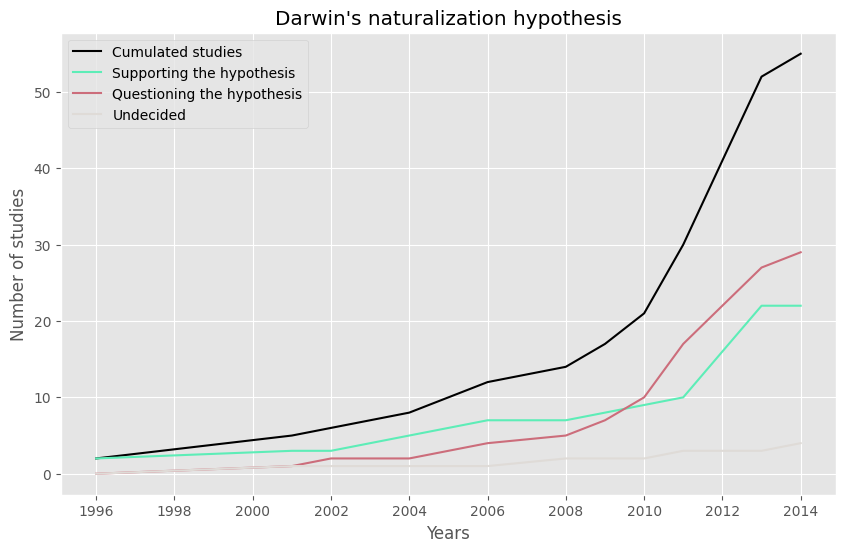

In [113]:
# Number of studies over the years
fig1, ax= plt.subplots(figsize=(10,6))
ax.plot('Study date','cumul', data = agg_year, color = "black")
ax.plot('Study date','cumul.support', data = agg_year, color = hi_colors.green)
ax.plot('Study date','cumul.question', data = agg_year, color = hi_colors.red)
ax.plot('Study date','cumul.ns', data = agg_year, color = hi_colors.grey)
#ax.stem('Study date','count', data = agg_year)
#ax.stem('Study date','count.support', data = agg_year, color = hi_colors.green)*

ax.legend(labels = ["Cumulated studies", "Supporting the hypothesis", "Questioning the hypothesis", "Undecided"])
ax.set_xlabel( "Years")
ax.set_ylabel("Number of studies")
ax.set_title("Darwin's naturalization hypothesis")


### Amount of support for the hypothesis

In [224]:
# support for the Hyp
support_H = df['support'].value_counts().reset_index(name='n')
support_H


# Contingency table of support per hypothesis and sub-hypothesis
crosstab_support_subH = pd.crosstab(df['support'], df['Measure of species relationship'],margins = False)

# other method using group by
grouped_subH =  df.groupby(["Measure of species relationship"])
support_subH = grouped_subH['support'].value_counts().reset_index(name='n')


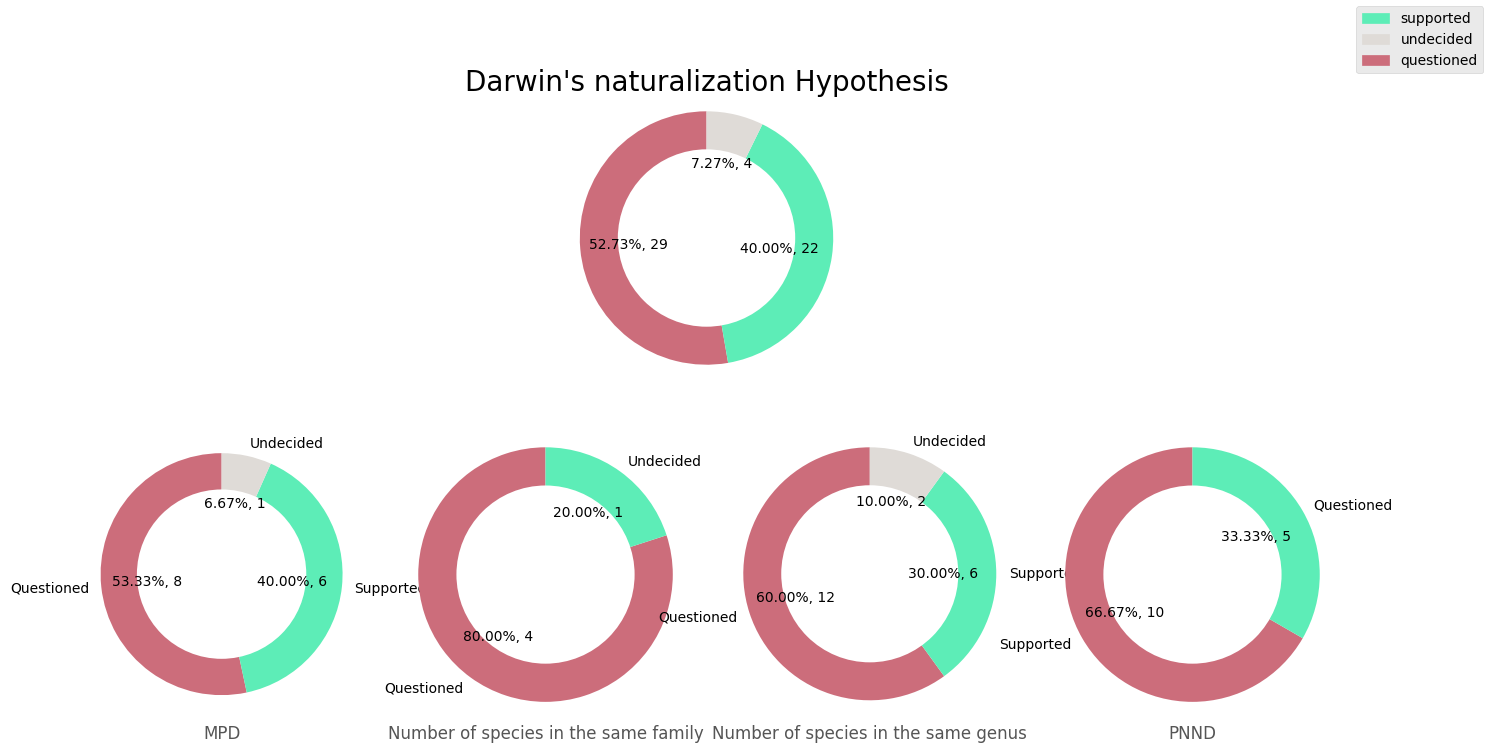

In [225]:
fig = plt.figure(figsize=(16,8))

#set up grid:
gs0 = fig.add_gridspec(2,1)
gs00 = gs0[0,0].subgridspec(1, 1)
gs01 = gs0[1,0].subgridspec(1, 4)

# plot overall support for hyp
vals = support_H.n

ax0 = fig.add_subplot(gs00[0,0])
ax0.pie(vals,colors = hi_colors,
  autopct=lambda p:f'{p:.2f}%, {p*sum(vals)/100 :.0f} ', startangle=90)

# Create a circle for the center of the plot
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax0.add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax0.axis('equal') 
plt.title("Darwin's naturalization Hypothesis",fontsize=20)

# legend
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color=hi_colors.green, label="supported")
grey_patch = mpatches.Patch(color=hi_colors.grey, label="undecided")
red_patch = mpatches.Patch(color=hi_colors.red, label="questioned")
fig.legend(handles=[green_patch,grey_patch,red_patch])


# plot support for all 4 subHyp
group_name = "Measure of species relationship"
levels = support_subH[group_name].unique()

for col in range(levels.size):
  m = levels[col]
  d = support_subH.groupby(group_name).get_group(m)
  vals = d.n
  ax = fig.add_subplot(gs01[0,col])

  ax.pie(vals,colors = hi_colors, labels = d.support,
    autopct=lambda p:f'{p:.2f}%, {p*sum(vals)/100 :.0f} ', startangle=90)
  ax.set_xlabel(m)

  # Create a circle for the center of the plot
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  ax.add_artist(centre_circle)

  # Equal aspect ratio ensures that pie is drawn as a circle
  ax.axis('equal') 

